# 9.1 説明の準備

## 9.1.1 環境構築

In [163]:
from pprint import pprint
import pandas as pd
import sklearn
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from matplotlib.text import Text
import numpy as np
import seaborn as sns

plt.style.use("ggplot")
sns.set(font="meiryo")

## 9.1.2 データセットの準備

In [164]:
# データセットの取得
X, y = shap.datasets.adult()

# 説明変数の表示
display(X.head(10))

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
5,37.0,4,14.0,2,4,5,4,0,0.0,0.0,40.0,39
6,49.0,4,5.0,3,8,0,2,0,0.0,0.0,16.0,23
7,52.0,6,9.0,2,4,4,4,1,0.0,0.0,45.0,39
8,31.0,4,14.0,4,10,0,4,0,14084.0,0.0,50.0,39
9,42.0,4,13.0,2,4,4,4,1,5178.0,0.0,40.0,39


In [165]:
# 目的変数の表示
print(y[:10])

[False False False False False False False  True  True  True]


In [166]:
# データサイズの表示
print(X.shape)

(32561, 12)


In [167]:
# 各列のデータ型の表示
print(X.dtypes)

Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int32
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object


In [168]:
# 各列の欠損数：欠損値がないことを確認
print(X.isna().sum())

Age               0
Workclass         0
Education-Num     0
Marital Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours per week    0
Country           0
dtype: int64


In [169]:
# カテゴリ変数の指定
for c in X.columns:
    if X[c].dtype == np.int8:
        # データ型を変更
        X[c] = X[c].astype("category")

# 各列のデータ型の表示
print(X.dtypes)

Age                float32
Workclass         category
Education-Num      float32
Marital Status    category
Occupation        category
Relationship         int32
Race              category
Sex               category
Capital Gain       float32
Capital Loss       float32
Hours per week     float32
Country           category
dtype: object


In [170]:
# 学習用とテスト用へのデータ分割
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

## 9.1.3 モデルの準備

In [171]:
# モデルの学習
model = lgb.LGBMClassifier()
model.fit(X_train.values, y_train)

# 予測値の算出
# predict_prop の返り値は（0の確率, 1の確率）の2列からなるので、1の確率のみを取り出す
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 予測値の評価
val = sklearn.metrics.roc_auc_score(y_test, y_pred_prob)
print(f"auc-rocスコア: {val}")

auc-rocスコア: 0.9286601680523197


In [172]:
# 予測値の混同行列
display(pd.crosstab(y_test, y_pred))

col_0,False,True
row_0,,
False,5891,318
True,668,1264


# 9.2 SHAP値の算出と理解

In [173]:
# 説明噐の準備～ SHAP 値算出
exp = shap.TreeExplainer(model)
sv_test = exp.shap_values(X_test)
sv_test = sv_test[1]
# もとのデータセットと同じサイズの行列が得られる
print(X_test.shape, sv_test.shape)

(8141, 12) (8141, 12)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [174]:
# SHAP 値の確認
print(sv_test[0])

[ 0.6392393   0.07053207  0.86902844  0.23583657  0.28962486  1.03415892
  0.02904955  0.11660464 -0.28348651 -0.09408222  0.35694668  0.02271171]


In [175]:
# SHAP 値の一致性の確認
print(exp.expected_value[1] + sv_test[0].sum(), y_pred_prob[0])

0.9975648323604873 0.7305795263027306


Text(0, 0.5, 'モデルの予測確率')

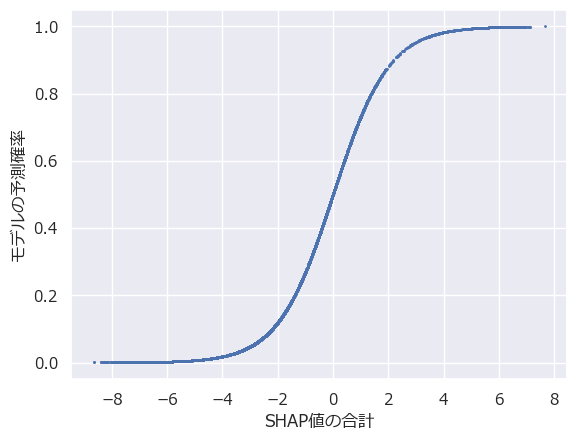

In [176]:
# SHAP 値の足し合わせのプロット
# SHAP 値の合計 + 平均値

sv_sum = sv_test.sum(axis=1) + exp.expected_value[1]
plt.scatter(sv_sum, y_pred_prob, s=1)
plt.xlabel("SHAP値の合計")
plt.ylabel("モデルの予測確率")
Text(0, 0.5, "モデルの予測確率")

In [177]:
# シグモイド関数を適用したSHAP値の一致性の確認
prob_shap = 1 / (1 + np.exp(-sv_sum))  # SHAP値から復元したモデルの予測確率
assert np.all(np.isclose(prob_shap, y_pred_prob))  # 値が一致している

## Column LightGBMのSHAP連携機能

In [178]:
# LightGBM モデルが持つ SHAP 値の計算結果の確認
pred = model.predict_proba(X_test)[:, 1]  # 元の予測確率
res = model.predict(X_test, pred_contrib=True)  # SHAP 値行列を復元
pred2 = 1 / (1 + np.exp(-(res[:, :-1].sum(axis=1) + res[:, -1])))  # 予測確率を復元
assert np.all(np.isclose(pred, pred2))  # SHAP ライブラリで計算した結果に一致する

# 9.3 SHAP値の可視化
## 9.3.1 個別の予測に対する特徴量の影響

In [179]:
shap.initjs() # Jupyter Notebook で SHAP 値のプロットを行う場合に必要
shap.force_plot(exp.expected_value[1], sv_test[0], X_test.iloc[0])

In the future `np.object` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

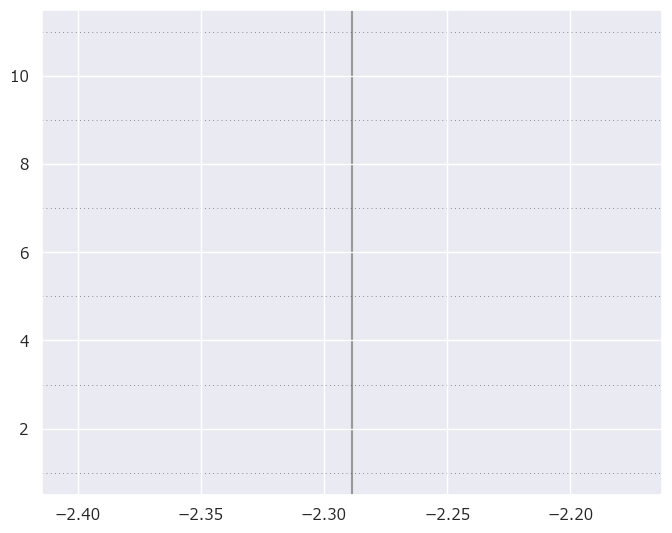

In [182]:
# 個別のデータに対する多数の特徴量の影響の可視化
# decision_plot: 特徴量の数が多い場合に
shap.decision_plot(exp.expected_value[1], sv_test[0], X_test.iloc[0])

## 9.3.2 データセット全体に対する特徴量の効き方

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


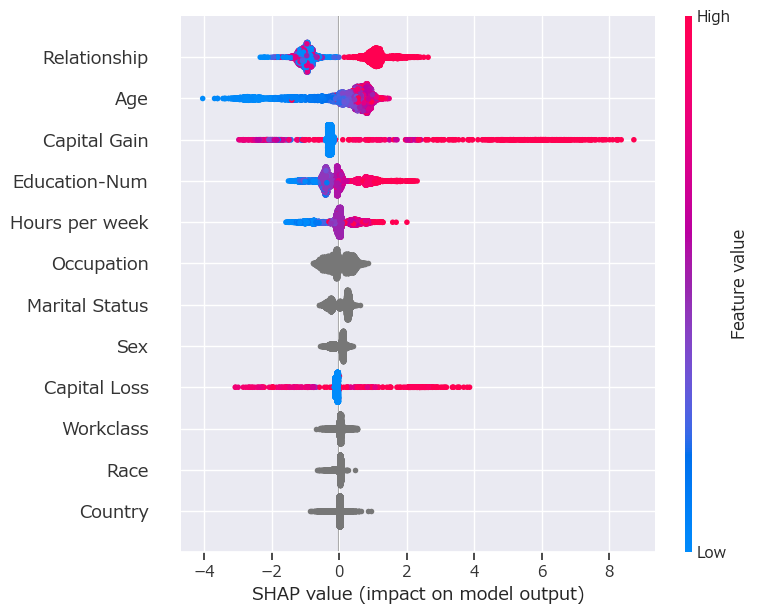

In [184]:
# データセット全体の特徴量の影響の可視化
shap.summary_plot(sv_test, X_test)

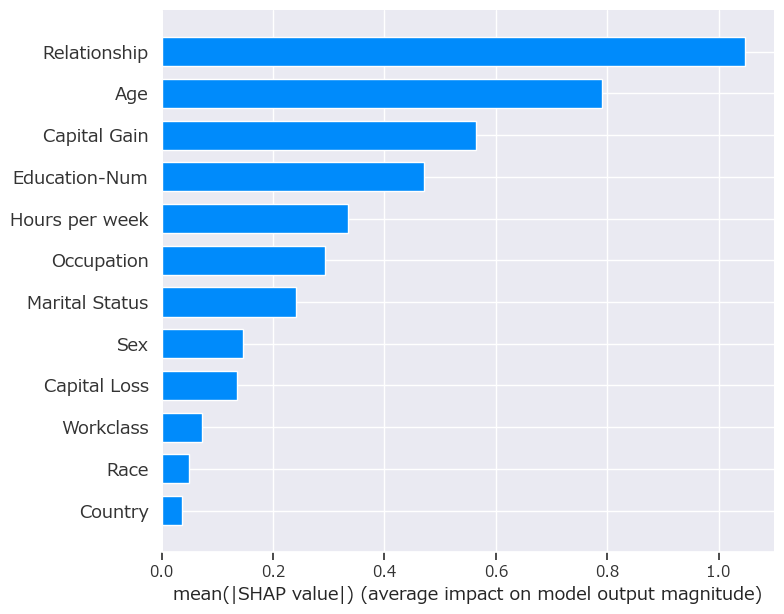

In [185]:
# データセット全体の特徴量の影響の可視化（棒グラフ）
shap.summary_plot(sv_test, X_test, plot_type="bar")